# Analysis pipeline for Specificity

## Preliminaries

In [1]:
%cd ~/code/textrec/

/Users/kcarnold/code/textrec


In [2]:
%matplotlib inline
import datetime
import json
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import toolz
from IPython.display import Image, HTML

In [3]:
from textrec.paths import paths
from textrec import analysis_util, util, notebook_util, automated_analyses
reload(analysis_util), reload(util), reload(notebook_util), reload(automated_analyses)
from textrec.notebook_util import images, id2img, id2url, show_images

Loading COCO captions
Loading COCO id2url
Done


/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.
Loading SpaCy...done
Loading COCO captions
Loading COCO id2url
Done
Loading SpaCy...done


In [4]:
# HTML(show_images([images_by_split['val'][0]['cocoid']]))

## Load results of writing experiment

Prerequisites: Run `textrec.logs_to_csv {batch_name}` and `textrec.gruntwork {batch_name}`.

In [23]:
batch = '2018-05-02'
experiment_level_data = pd.read_csv(paths.analyzed / f'experiment_{batch}.csv')
block_level_data = pd.read_csv(paths.analyzed / f'block_{batch}.csv')
trial_level_data = pd.read_csv(paths.analyzed / f'trial_withmanual_{batch}.csv')
helpful_ranks_by_condition = pd.read_csv(paths.analyzed / f'helpful_ranks_by_condition_{batch}.csv')

In [25]:
helpful_ranks_by_condition.set_index('index')

,accurate-least-condition,accurate-most-condition,quick-least-condition,quick-most-condition,specific-least-condition,specific-most-condition
index,,,,,,
general,2,4,1,5,2,6
norecs,19,2,22,2,20,2
specific,4,19,2,18,3,17


In [6]:
HTML("Each of {num_participants} participants ({non_male} non-male) completed {num_trials_per} trials per experiment, for a total of {n_trials} trials.".format(
    num_participants=len(set(trial_level_data.participant)),
    non_male=(experiment_level_data.gender == 'Male').sum(),
    num_trials_per=trial_level_data.groupby('participant').size().mean(),
    n_trials=len(trial_level_data)))

In [7]:
HTML("Participants spent {total_time_mean:.1f} +- {total_time_std:.1f} minutes total.".format(
    total_time_mean=experiment_level_data.total_time.mean(),
    total_time_std=experiment_level_data.total_time.std()))

In [8]:
def summarize_means(df, by, outcome):
    return ', '.join(f'{name}={group_mean:.2f}' for name, group_mean in df.groupby(by)[outcome].mean().iteritems())

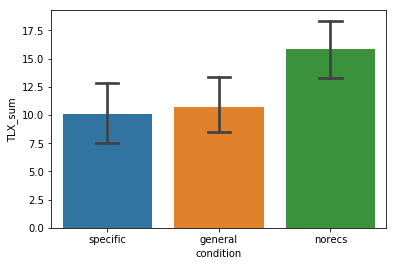

In [9]:
sns.barplot(x='condition', y='TLX_sum', data=block_level_data, capsize=.2)
HTML("The average cognitive load was higher in the no-recommendations condition ({})".format(
    summarize_means(block_level_data, 'condition', 'TLX_sum')))

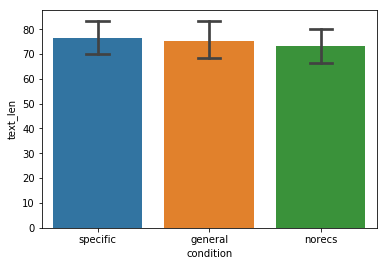

In [10]:
sns.barplot(x='condition', y='text_len', data=trial_level_data, capsize=.2);
HTML("There was no difference in text length between conditions ({}).".format(
    summarize_means(trial_level_data, 'condition', 'text_len')))

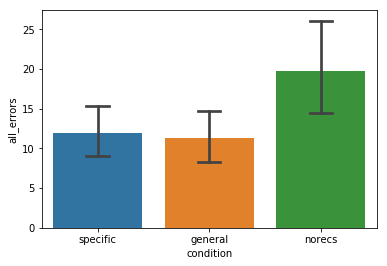

In [11]:
sns.barplot(x='condition', y='all_errors', data=trial_level_data, capsize=.2)
HTML("Participants made more errors (corrected + uncorrected) in the no-recommendations condition ({}).".format(
    summarize_means(trial_level_data, 'condition', 'all_errors')))

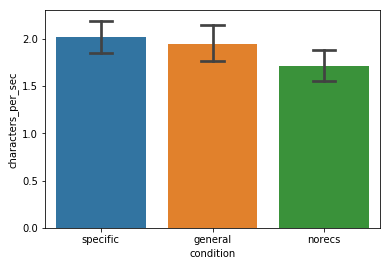

In [12]:
sns.barplot(x='condition', y='characters_per_sec', data=trial_level_data, capsize=.2)
HTML("Participants were slightly faster in the recommendations conditions (characters per second: {}).".format(
    summarize_means(trial_level_data, 'condition', 'characters_per_sec')))

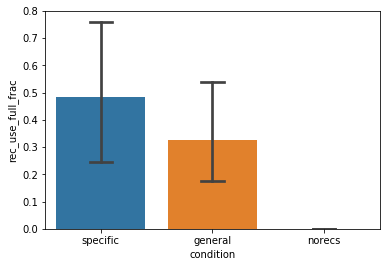

In [19]:
sns.barplot(x='condition', y='rec_use_full_frac', data=trial_level_data, capsize=.2)
HTML("Participants used available recommendations slightly more often when they were specific (use rate: {}).".format(
    summarize_means(trial_level_data, 'condition', 'rec_use_full_frac')))

In [20]:
print('\n\n'.join(x for x in experiment_level_data['techDiff'] if x is not None))

None

None

Mone

No

None

None

No

No issues

No 

No

None

No

No

None

None

Nope

None.

No

None

Just the fact that the third photo in keyboard 1 never loaded.

None

None

None

None

No. 


In [22]:
print('\n\n'.join(x for x in experiment_level_data['other'] if isinstance(x, str)))

No, I really enjoyed this task ☺️

None

None

It went well but my initial survey responses might not be in complete alignment with my final responses on this page.  That's because seeing my captions on this page gave me a better perspective with the benefit of hindsight.  Thanks for the HIT!  I did my best and hope the data is useful!

Being able to not have to backspace to redo typing

None

None

None

None

None

This was very annoying

Everything was great. First and third were pretty equal. Second was awful.

It went smooth no issues 

None

Everything went smoothly. Thank you

Can I type this one on the computer? One: I love the fact that after going to this page straight from the HIT on my computer, the page stayed synced when I went to it from my phone. There are some HITs I've done that could really benefit from that little nicety. Two: I feel like the suggestions really tend toward making me lazy, to some small extent. Having to type it all, you have to think about what to s

# Annotator-level data
TODO: script this.

In [13]:
annotator_level_data = pd.read_csv('unused/annotator_level_data_2018-05-22v2.csv')

In [14]:
annotator_level_data.columns

Index(['block', 'condition', 'exclude', 'idx', 'idx_in_block', 'num_resized',
       'num_tapBackspace', 'num_tapKey', 'num_tapSugg_any', 'num_tapSugg_bos',
       'num_tapSugg_full', 'num_tapSugg_part', 'num_tapText', 'writer',
       'stimulus', 'text', 'guesser', 'num_guesses', 'stimulus_url'],
      dtype='object')

In [16]:
annotator_level_data['first_guess'] = annotator_level_data['num_guesses'] == 1

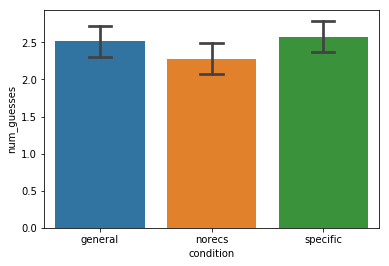

In [15]:
sns.barplot(x='condition', y='num_guesses', data=annotator_level_data, capsize=.2)

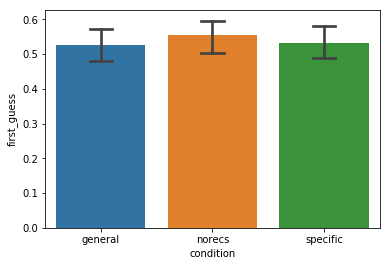

In [17]:
sns.barplot(x='condition', y='first_guess', data=annotator_level_data, capsize=.2)

# Generate nAFC task

For each stimulus image, choose a foil set. It should be about equally difficult for each condition. Simplest approach: find the nearest caption to the concatenation of all captions we got for that image.

TODO: should we be computing similarities of individual captions, rather than complete images?

In [ ]:
cap_vectorizer, caption_vecs = util.get_vectorized_captions()

In [ ]:
caption_vecs.shape

In [ ]:
id2url[570528]

In [ ]:
concat_captions = {stimulus: '\n'.join(toolz.pluck('text', trials))
                   for stimulus, trials in toolz.groupby('stimulus', trial_data).items()}
concat_captions.keys()

In [ ]:
# print(concat_captions[71815])
# print(concat_captions[275449])
print(concat_captions[396295])

For 275449, the foil images are fixated on the 'wine'. But unsurprising, since all but one caption mentions it, and it's probably less common than "cat".

In [ ]:
def get_similar_images(caption, n=10):
    query_vec = cap_vectorizer.transform([caption])
    similarity = caption_vecs.dot(query_vec.T).A.ravel()
    return [images[idx]['cocoid'] for idx in np.argsort(similarity)[-n:][::-1]]
query_caption = concat_captions[396295].replace('wine', '') #trial_data[0]['text']
# query_caption = "a rusty and dirty shower in the bathroom has a tan towel over its handle"
# query_caption = "a sliding glass shower door with a bath mat hanging on it"
query_caption = "a closed shower door with crackled glass encases some hanging colored toiletries"
# print(query_caption)
# HTML(show_images(get_similar_images(query_caption)))

In [ ]:
def get_foil_set(*, stimulus, caption, rs):
    similar_images = get_similar_images(caption, n=10)
    if stimulus not in similar_images:
        print("Inserting", stimulus, 'into foil set')
        similar_images[-1] = stimulus
    rs.shuffle(similar_images)
    return similar_images
stimulus = trial_data[1]['stimulus']
get_foil_set(stimulus=stimulus, caption=concat_captions[stimulus], rs=np.random.RandomState(1234))

In [ ]:
rs = np.random.RandomState(1234)
foil_sets = {
    stimulus: get_foil_set(stimulus=stimulus, caption=concat_captions[stimulus], rs=rs)
    for stimulus in sorted(concat_captions.keys())}

Group tasks so that (1) each annotator never gets the same target image twice and (2) each annotator never sees two captions from the same person. The latter criterion cannot always be met, though, since the number of annotators may not evenly divide the number of participants.

In [ ]:
import random
def shuffled(lst):
    lst = lst[:]
    random.shuffle(lst)
    return lst

In [ ]:
while True:
    trials_by_img = toolz.groupby('stimulus', shuffled(trial_data))
    annotators = []
    while not any(len(trials) == 0 for trials in trials_by_img.values()):
        trials_for_annotator = []
        participants_seen_by_annotator = set()
        for stimulus, trials in trials_by_img.items():
            for i in range(len(trials)):
                participant = trials[i]['participant']
                if participant not in participants_seen_by_annotator:
                    trials_for_annotator.append(trials.pop(i))
                    participants_seen_by_annotator.add(participant)
                    break
            else:
#                 print("Have to use the same participant again")
                trials_for_annotator.append(trials.pop(0))

        annotators.append(shuffled(trials_for_annotator))
    if all(len(set(toolz.pluck('participant', trials))) == len(trials) for trials in annotators):
        break
    assert all(len(trials) == 0 for trials in trials_by_img.values())

In [ ]:
a = annotators[:]

In [ ]:
trials_by_img

Check that each annotator never gets the same target image twice

In [ ]:
assert all(len(set(toolz.pluck('stimulus', trials))) == len(trials) for trials in annotators)

Check that each annotator never sees two captions from the same person.

In [ ]:
assert all(len(set(toolz.pluck('participant', trials))) == len(trials) for trials in annotators)

In [ ]:
[len(trials) for trials in annotators]

In [ ]:
len(annotators)

In [ ]:
def make_task(stimulus, text):
    foil_set = foil_sets[stimulus]
    return dict(
        description=text,
        correct_idx=foil_set.index(stimulus),
        images=[id2url[idx] for idx in foil_set]
    )

In [ ]:
trial = annotators[0][0]
make_task(trial['stimulus'], trial['text'])

In [ ]:
guesses_task = pd.DataFrame([
    json.dumps([make_task(trial['stimulus'], trial['text']) for trial in annotator_trials])
    for annotator_trials in annotators], columns=['task'])
guesses_task.iloc[:1].to_csv(str(paths.data / 'anno-tasks' / 'guesses_test.csv'), index=False)
guesses_task.iloc[1:].to_csv(str(paths.data / 'anno-tasks' / 'guesses_remain.csv'), index=False)
guesses_task.to_csv(str(paths.data / 'anno-tasks' / 'guesses.csv'), index=False)

### Load MTurk results so far

In [ ]:
result_files = list((paths.data / 'mturk').glob('*-guesses.csv'))
batched_guesses_results = (
    pd.concat([pd.read_csv(str(f)) for f in result_files], axis=0, ignore_index=True)
)

In [ ]:
%matplotlib inline

In [ ]:
(batched_guesses_results['WorkTimeInSeconds']/60).hist(bins=30)

In [ ]:
def get_active_dur(results):
    pages = json.loads(results)
    try:
        first_guess = pages[0]['guesses'][0]['timestamp']
        last_guess = pages[-1]['guesses'][-1]['timestamp']
        return (last_guess - first_guess) / 1000 / 60
    except IndexError:
        # Something failed in the UI probably...
        return None
batched_guesses_results['Answer.results'].apply(get_active_dur).hist()
batched_guesses_results['Answer.results'].apply(get_active_dur).describe()
        

In [ ]:
batched_guesses_results[batched_guesses_results['Answer.results'].apply(lambda x: '"guesses":[]' in x)].T

In [ ]:
%debug

In [ ]:
guesses_results = []
for i, row in batched_guesses_results.iterrows():
    for page in json.loads(row['Answer.results']):
#         print(page)
        guess_indices = [guess['idx'] for guess in page['guesses']]
        if len(guess_indices) == 0:
            print("UI fail", row['WorkerId'])
            continue
#         guessed_right_sometime = [row.correctIdx in row.guess_indices for row in mturk_nafc_results.itertuples()]
        stimulus_url = [img for img in page['images'] if img['isCorrect']][0]['url']
        guesses_results.append(dict(
            guesser=row['WorkerId'],
            description=page['description'],
            num_guesses=len(guess_indices),
            stimulus_url=stimulus_url))
pd.DataFrame(guesses_results)

In [ ]:
num_responses_by_caption = mturk_nafc_results.groupby('Answer.description').size().to_dict()

### Generate tasks remaining

In [ ]:
# trials_todo = [trial for trial in trial_data if num_responses_by_caption.get(trial['text'], 0) < 3]
# len(trial_data), len(trials_todo)

In [ ]:
# i = 0
# while True:
#     out_fn = paths.data / 'anno-tasks' / f'{datetime.date.today().isoformat()}-{i}-nAFC.csv'
#     if not out_fn.exists():
#         break
#     i += 1
# out_fn

In [ ]:
# rs = np.random.RandomState(1234)
# pd.DataFrame([make_task(trial, rs) for trial in trials_todo]).to_csv(out_fn, index=False)

### Generate the actual HIT text...

In [ ]:
from jinja2 import Template
html = Template(open(paths.top_level / 'HITs' / '2018-05-04-image-description-match.jinja.html').read()).render(dict(
    description='${description}',
    images=['${image_%d_url}' % i for i in range(10)]))

In [ ]:
html2 = html
trial = trial_data[18+7*9]
for k, v in make_task(trial['stimulus'], trial['text']).items():
    html2 = html2.replace('${' + k + '}', str(v))
HTML('<div style="height: 1000px; position: relative;">'+html2+'</div>')
# print(html2)

In [ ]:
import subprocess
subprocess.Popen('pbcopy', stdin=subprocess.PIPE).communicate(html.encode('utf-8'))

# Analyze MTurk results

In [ ]:
mturk_nafc_results.groupby('Answer.description').num_guesses.mean().to_dict()

In [ ]:
%matplotlib inline

In [ ]:
(mturk_nafc_results['WorkTimeInSeconds'][mturk_nafc_results['WorkTimeInSeconds'] < 5*60] / 60).hist(bins=30)

In [ ]:
np.median(mturk_nafc_results['WorkTimeInSeconds'] / 60) * 9/60

In [ ]:
(
    15 # participants
    * 3 # conditions per participant
    * 3 # captions per condition
    - 1 # image not shown
) * 3 # annotators per description


In [ ]:
    * .24 # reward per annotator
) * 1.2 # MTurk 20% fee

Did the same worker see the same target image multiple times?

In [ ]:
next(data.iterrows())[1]['Input.image_0_url']

In [ ]:
mturk_nafc_results['target_image_url'] = [row['Input.image_'+str(row['correctIdx'])+"_url"] for _, row in mturk_nafc_results.iterrows()]

In [ ]:
bad_worker_image_pairs = set()
for worker_id, data in mturk_nafc_results.groupby('WorkerId'):
    target_images = [row['target_image_url'] for _, row in data.iterrows()]
    if len(target_images) != len(set(target_images)):
#         print(worker_id)
        value_counts = pd.Series(target_images).value_counts()
        value_counts = value_counts[value_counts > 1]
#         print(value_counts)
        for img in value_counts.index:
            bad_worker_image_pairs.add((worker_id, img))
bad_worker_image_pairs

annotation_row_is_bad = [
    (row['WorkerId'], row['target_image_url']) in bad_worker_image_pairs
    for _, row in mturk_nafc_results.iterrows()
]
mturk_nafc_results['row_is_bad'] = annotation_row_is_bad

In [ ]:
mturk_nafc_results['row_is_bad'].mean()

In [ ]:
guess_results = mturk_nafc_results[~mturk_nafc_results['row_is_bad']].rename(columns={'Answer.description': 'text'})

In [ ]:
len(mturk_nafc_results)

In [ ]:
len(guess_results), len(trial_data)

In [ ]:
trial_data

In [ ]:
annotator_level_data = pd.merge(
    pd.DataFrame(trial_data).rename(columns={'participant': 'writer'}),
    guess_results.rename(columns={'WorkerId': 'guesser'}).drop(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'RequesterAnnotation', 'guesses'], axis=1),
    on='text', validate='1:m', how='right')
annotator_level_data
    #.groupby().num_guesses.mean().to_frame('mean_num_guesses'),
#     left_on='text', right_index=True).groupby('condition').mean_num_guesses.aggregate(['mean', 'std'])

In [ ]:
guesses_results[0]

In [ ]:
annotator_level_data = pd.merge(
    pd.DataFrame(trial_data).rename(columns={'participant': 'writer'}),
    pd.DataFrame(guesses_results).rename(columns={'description': 'text'}),
    on='text', validate='1:m', how='right')
annotator_level_data
    #.groupby().num_guesses.mean().to_frame('mean_num_guesses'),
#     left_on='text', right_index=True).groupby('condition').mean_num_guesses.aggregate(['mean', 'std'])

In [ ]:
annotator_level_data.columns

In [ ]:
annotator_level_data.to_csv('annotator_level_data_2018-05-22v2.csv', index=False)

In [ ]:
(annotator_level_data['num_guesses'] == 1).mean()

In [ ]:
%pwd

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(lme4)
library(ggplot2)

In [ ]:
%%R -i annotator_level_data
(model = lmer(num_guesses ~ condition + (1|writer) + (1|guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R -i annotator_level_data
(null_model = lmer(num_guesses ~ (1|writer) + (1|guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R
library(pbkrtest)

In [ ]:
%%R
(kr <- KRmodcomp(model, null_model))

In [ ]:
%%R -i annotator_level_data
(glm.full = glmer(num_guesses ~ condition + (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data, family=poisson()))

In [ ]:
%%R
(glm.null = glmer(num_guesses ~ (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data, family=poisson()))

In [ ]:
%%R
#confint(glm.full)

In [ ]:
%%R
anova(glm.full, glm.null, test="Chisq")

In [ ]:
%%R -i annotator_level_data
(nb_model = glmer.nb(num_guesses ~ condition + (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R -i annotator_level_data
(nb_model.null = glmer.nb(num_guesses ~ (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R
anova(nb_model, nb_model.null, test="Chisq")

In [ ]:
results = pd.DataFrame([dict(trial, specificity=specificity_lookup[trial['text'].strip()]) for trial in trial_data])
for col in ['condition', 'participant']:
    results[col] = results[col].astype('category')
results.info()

In [ ]:
results.groupby('condition').specificity.mean()

In [ ]:
pd.DataFrame(trial_data).sample(frac=1.0).sort_values('stimulus').to_csv('trial_data_by_stimulus.csv')

# How many images does this caption apply to?

In [ ]:
data = pd.read_csv("/Users/kcarnold/Downloads/Submitted Captions - Sheet1.csv").iloc[:,:6]

In [ ]:
data

In [ ]:
data.shape

In [ ]:
data = data.dropna().copy()
data.shape

In [ ]:
data['is_unique'] = (data.iloc[:,5] == '1')
data.is_unique.mean()

In [ ]:
data.groupby(['block', 'idx_in_block', 'condition']).is_unique.mean()

In [ ]:
data['participant'] = data['participant'].astype('category')
data['condition'] = data['condition'].astype('category')

In [ ]:
data.groupby('condition').is_unique.mean()

In [ ]:
%%R -i data
transformed <- art(is_unique ~ condition + (1|participant), data=data)
summary(transformed)
anova(transformed)

In [ ]:
example = trial_data[-1]['text']
example

Concepts: traffic light. COCO doesn't have "pedestian crossing sign". There are 4330 images with traffic lights in them in COCO. That's way too much. Looking at Visual Genome.

Visual Genome synsets are potentially best, but they're sometimes inaccurate. e.g., "18 wheeler" is "cyclist.n.01". So let's consider an object a match if matches either the synset or object name.

In [ ]:
vg_base = pathlib.Path('/Data/VisualGenome')
image_objects = json.load(open(vg_base / 'objects.json'))

In [ ]:
img_by_id = {img['image_id']: img for img in image_objects}

In [ ]:
obj_synsets = json.load(open(vg_base / 'object_synsets.json'))

In [ ]:
obj_attributes = json.load(open(vg_base / 'attributes.json'))

In [ ]:
len(obj_attributes), len(image_objects)

In [ ]:
obj_attributes[0].keys()

In [ ]:
attributes_by_img = {att['image_id']: att['attributes'] for att in obj_attributes}

In [ ]:
attributes_by_img[61514]

In [ ]:
# def has_object(obj_name):
#     return {
#         img['image_id'] for img in image_objects
#         if any(obj_name in '\n'.join(obj['names']) for obj in img['objects'])
#            }
def has_object(imgid, obj_name):
    return any(obj_name in '\n'.join(obj['names']) for obj in attributes_by_img[imgid])

In [ ]:
# def has_synset(obj_synset):
#     return {
#         img['image_id'] for img in image_objects
#         if any(obj_synset in obj['synsets'] for obj in img['objects'])}
def has_synset(imgid, obj_synset):
    return any(obj_synset in obj['synsets'] for obj in attributes_by_img[imgid])

In [ ]:
def has_obj_with_attr(imgid, obj_name, attr):
    return any(
        (obj_name in '\n'.join(obj['names'])) and (attr in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

def has_synset_with_attr(imgid, obj_synset, attr):
    return any(
        (obj_synset in obj['synsets']) and (attr in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

def has_obj_without_attr(imgid, obj_name, attr):
    return any(
        (obj_name in '\n'.join(obj['names'])) and (attr not in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

def has_synset_without_attr(imgid, obj_synset, attr):
    return any(
        (obj_synset in obj['synsets']) and (attr not in obj.get('attributes', []))
        for obj in attributes_by_img[imgid])

In [ ]:
obj_synsets['pedestrian sign']

In [ ]:
# candidates = (
#     (has_object('pedestrian sign') | has_object('pedestrian crossing sign') | has_object('crossing sign') | has_object('sign')) &
#     (has_object('traffic light') | has_synset('traffic_light.n.01'))
# )
candidates = {
    imgid for imgid in attributes_by_img.keys()
    if (
        (
            has_object(imgid, 'pedestrian sign') |
            has_object(imgid, 'pedestrian crossing sign') |
            has_object(imgid, 'crossing sign') |
            has_obj_with_attr(imgid, 'sign', 'yellow')
        ) & (
            has_obj_without_attr(imgid, 'traffic light', 'red') |
            has_synset_without_attr(imgid, 'traffic_light.n.01', 'red')
        ))}
len(candidates)

In [ ]:
show_images(candidates)

In [ ]:
[img['image_id'] for img in image_objects if '61514' in img.get('image_url', '')]
#Image(img_by_id[61514]['image_url'])

In [ ]:
img_by_id[61514]

# Measuring Specificity

We use paired comparisons to analyze specificity and accuracy. For a target image $x$ and a fixed set of imposter images $Y$, the **specific accuracy** of a caption is the fraction of comparisons that chose $x$. 

We start with our dataset of paired comparisons.

In [ ]:
captions = [
    "exactly how are both the dog and the person going to fit on that skateboard?",
    "the dark haired dog is trying to ride on the skateboard.",
    "a person in shorts and a black dog both have one foot on a skateboard.",
    "a dog with a black head and black legs and ears standing up has one black paw on a black skateboard with white wheels and a guy with black and white shoes and white socks has one foot on the skateboard also and there are bikes and other people in the background"
]

In [ ]:
alternatives = 'dog-and-guy-on-skateboard just-dog-on-skateboard guy-on-skateboard-holding-dog dog-and-guy-next-to-skateboard'.split()
target = alternatives[0]
imposters = alternatives[1:]
applies_to = [
    'dog-and-guy-on-skateboard dog-and-guy-next-to-skateboard'.split(),
    'just-dog-on-skateboard'.split(),
    'dog-and-guy-on-skateboard'.split(),
    'dog-and-guy-on-skateboard just-dog-on-skateboard guy-on-skateboard-holding-dog dog-and-guy-next-to-skateboard'.split()
]
applies_to = {cap: tgts for cap, tgts in zip(captions, applies_to)}
applies_to

In [ ]:
import random
random.seed(0)
pairs = [[target, imposter] for imposter in imposters]
for pair in pairs:
    random.shuffle(pair)
pairs

In [ ]:
def fake_answer_pairs_for_caption(applies, pairs):
    outcomes = []
    for a, b in pairs:
        choices = []
        if a in applies:
            choices.append(0)
        if b in applies:
            choices.append(1)
        if len(choices) == 0:
            choices = [0, 1]
        outcomes.append(random.choice(choices))
    return outcomes
fake_answer_pairs_for_caption(applies_to[captions[0]], pairs)

In [ ]:
fake_comparisons_data = []
for caption in captions:
    for annotator in range(5):
        for pair, outcome in zip(pairs, fake_answer_pairs_for_caption(applies_to[caption], pairs)):
            picked = pair[outcome]
            fake_comparisons_data.append(dict(
                caption=caption,
                annotator=annotator,
                pair=pair,
                picked=picked))

In [ ]:
data = pd.DataFrame(fake_comparisons_data)
len(data)

In [ ]:
data['picked_correct'] = data['picked'] == 'dog-and-guy-on-skateboard'
data.groupby('caption').picked_correct.mean().sort_values()

# Final analyses

We find a main effect of writing condition on outcome specificity.

In [ ]:
%load_ext rpy2.ipython

In [ ]:
results = pd.DataFrame([
    dict(participant_id=participant_id, condition=condition)
    for participant_id in 'abc def ghi'.split() for condition in 'general specific norecs'.split()
])
results['participant_id'] = results['participant_id'].astype('category')
results['condition'] = results['condition'].astype('category')
results['specificity'] = np.random.randn(len(results))

In [ ]:
%%R
#install.packages("ARTool")
library(ARTool)

In [ ]:
%%R -i results
summary(results)

In [ ]:
%%R -i results
transformed <- art(specificity ~ condition + (1|participant), data=results)
summary(transformed)
anova(transformed)